In [1]:
import gym
from gym.wrappers import Monitor
from collections import deque
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import math
import time
import glob
import io
import base64
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt 
from IPython.display import HTML
from IPython import display as ipythondisplay

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# TRAINING
MAX_STEPS_PER_EPISODE = 10000

# AGENT HYPERPARAMETERS
LEARNING_RATE = 0.0001
DISCOUNT_FACTOR = 0.99
EXPLORATION_RATIO = 1.0
E_DECAY_LIMIT = 0.05
EXPLORATION_RATIO_INTERVAL = EXPLORATION_RATIO - E_DECAY_LIMIT
BATCH_SIZE = 64
MEM_BUFFER = 100000
FRAMES_2_TARGET = 8000

# LOAD/SAVE MODELS
LOAD_MODEL = True
MODEL_H5_FILEPATH = "resources/models/breakoutramdqn/saved_model_ep3424_rw54.h5"
SAVE_THRESHOLD = 55


# MISC
REPORT_FILE = False
STEPS_REPORT = 50

env = gym.make('Breakout-ram-v0')
NUM_FEATURES = env.observation_space.shape[0]
NUM_ACTIONS = env.action_space.n
print('Number of state features: {}'.format(NUM_FEATURES))
print('Number of possible actions: {}'.format(NUM_ACTIONS))
print(env.unwrapped.get_action_meanings())
print('Reward Range:', env.reward_range)
print(env.metadata)
print(env.spec)

Number of state features: 128
Number of possible actions: 4
['NOOP', 'FIRE', 'RIGHT', 'LEFT']
Reward Range: (-inf, inf)
{'render.modes': ['human', 'rgb_array']}
EnvSpec(Breakout-ram-v0)


A.L.E: Arcade Learning Environment (version +978d2ce)
[Powered by Stella]


In [3]:
def create_q_model():
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=(NUM_FEATURES,1))

    # Convolutions on the frames on the screen
    layer1 = layers.Conv1D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv1D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv1D(64, 3, strides=1, activation="relu")(layer2)

    layer4 = layers.Flatten()(layer3)

    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(NUM_ACTIONS, activation="linear")(layer5)

    return keras.Model(inputs=inputs, outputs=action)

if LOAD_MODEL:
    model = tf.keras.models.load_model(MODEL_H5_FILEPATH)
    model_target = tf.keras.models.load_model(MODEL_H5_FILEPATH)
else:
    model = create_q_model()
    model_target = create_q_model()

optimizer = keras.optimizers.Adam(LEARNING_RATE)
loss_function = keras.losses.MeanSquaredError()
# Using huber loss for stability
# loss_function = keras.losses.Huber()

2022-02-06 15:43:21.452222: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def select_epsilon_greedy_action(state, epsilon, epsilon_random_frames, frame_count):
    """Take random action with probability epsilon, else take best action."""
    if frame_count < epsilon_random_frames or epsilon > tf.random.uniform((1,)):
        # Take random action
        action = env.action_space.sample()
    else:
        # Predict action Q-values
        # From environment state
        state_tensor = tf.convert_to_tensor(state)
        state_tensor = tf.expand_dims(state_tensor, 0)
        action_probs = model(state_tensor, training=False)
        # Take best action
        action = tf.argmax(action_probs[0]).numpy()
    return action

In [5]:
# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
last_100_ep_rewards = []
running_reward = 0
episode_count = 0
frame_count = 0
# Number of frames to take random action and observe output
epsilon_random_frames = 50000
# Number of frames for exploration
epsilon_greedy_frames = 1000000.0
# Maximum replay length
# Note: The Deepmind paper suggests 1000000 however this causes memory issues
max_memory_length = 100000
# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 10000

time_elapsed = time.time()
while True:  # Run until solved
    state = np.array(env.reset())
    episode_reward = 0
    
    for timestep in range(1, MAX_STEPS_PER_EPISODE):
        # env.render(); Adding this line would show the attempts
        # of the agent in a pop up window.
        frame_count += 1

        # Use epsilon-greedy for exploration
        action = select_epsilon_greedy_action(state, EXPLORATION_RATIO, epsilon_random_frames, frame_count)

        # Decay probability of taking random action
        EXPLORATION_RATIO -= EXPLORATION_RATIO_INTERVAL / epsilon_greedy_frames
        EXPLORATION_RATIO = max(EXPLORATION_RATIO, E_DECAY_LIMIT)

        # Apply the sampled action in our environment
        state_next, reward, done, info = env.step(action)
        state_next = np.array(state_next)

        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > BATCH_SIZE:

            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=BATCH_SIZE)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + DISCOUNT_FACTOR * tf.reduce_max(
                future_rewards, axis=1
            )

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, NUM_ACTIONS)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            # template = "running reward: {:.2f} at episode {}, frame count {}"
            # print(template.format(running_reward, episode_count, frame_count))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Si el modelo supera el umbral, lo guardo y aumento el umbral.
    if episode_reward >= SAVE_THRESHOLD:
        model.save('resources/models/breakoutramdqn/saved_model_ep'+str(episode_count)+'_rw'+str(int(episode_reward))+'.h5')
        SAVE_THRESHOLD += 5
        print("\tIn episode {} we archived {} reward, {} is the new threshold to save. Saving model!".format(episode_count, episode_reward, SAVE_THRESHOLD))
        
    
    # Update running reward to check condition for solving
    if len(last_100_ep_rewards) == 100:
        last_100_ep_rewards = last_100_ep_rewards[1:]
    last_100_ep_rewards.append(episode_reward)
    episode_reward_history.append(episode_reward)
    
    if episode_count % STEPS_REPORT == 0:
        print(f'Episode {episode_count}. Epsilon: {EXPLORATION_RATIO:.3f}. 'f'Reward in last 100 episodes: {np.mean(last_100_ep_rewards):.3f}. Info: {info}. Elapsed time: {int(time.time()-time_elapsed)}')
        time_elapsed = time.time()

    episode_count += 1

    if np.mean(last_100_ep_rewards) > 40:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break

Episode 0. Epsilon: 1.000. Reward in last 100 episodes: 2.000. Info: {'lives': 0}. Elapsed time: 2
Episode 50. Epsilon: 0.988. Reward in last 100 episodes: 1.275. Info: {'lives': 0}. Elapsed time: 124
Episode 100. Epsilon: 0.977. Reward in last 100 episodes: 1.250. Info: {'lives': 0}. Elapsed time: 127
Episode 150. Epsilon: 0.965. Reward in last 100 episodes: 1.270. Info: {'lives': 0}. Elapsed time: 130
Episode 200. Epsilon: 0.954. Reward in last 100 episodes: 1.140. Info: {'lives': 0}. Elapsed time: 124
Episode 250. Epsilon: 0.941. Reward in last 100 episodes: 1.390. Info: {'lives': 0}. Elapsed time: 160
Episode 300. Epsilon: 0.929. Reward in last 100 episodes: 1.780. Info: {'lives': 0}. Elapsed time: 156
Episode 350. Epsilon: 0.916. Reward in last 100 episodes: 1.770. Info: {'lives': 0}. Elapsed time: 163
Episode 400. Epsilon: 0.903. Reward in last 100 episodes: 1.870. Info: {'lives': 0}. Elapsed time: 170
Episode 450. Epsilon: 0.890. Reward in last 100 episodes: 2.010. Info: {'lives

KeyboardInterrupt: 

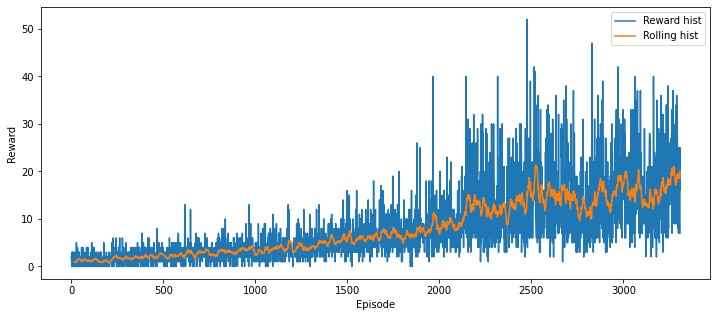

In [6]:
plt.figure(figsize = (12, 5))

numbers_series = pd.Series(episode_reward_history)

rolling_numbers_series = numbers_series.rolling(20).mean()

plt.plot(episode_reward_history, label="Reward hist")
plt.plot(rolling_numbers_series, label="Rolling hist")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()

In [7]:
def show_video():
    mp4list = glob.glob('resources/videos/breakoutramdqn/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Video not found")
    

def wrap_env(env):
    env = Monitor(env, './resources/videos/breakoutramdqn', force=True)
    return env

In [8]:
env = wrap_env(gym.make('Breakout-ram-v0', render_mode='rgb_array'))
state = np.array(env.reset())
done = False
ep_rew = 0
while not done:
    env.render()
    # state = tf.expand_dims(state, axis=0)
    action = select_epsilon_greedy_action(state, 0, 1, 1)
    state, reward, done, info = env.step(action)
    state = np.array(state)
    ep_rew += reward
print('Episode reward was {}'.format(ep_rew))
env.close()
show_video()

2022-02-06 23:36:19.302 Python[20799:8592644] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/d8/pjwlqxxx6gsgk0rr17sh7x280000gn/T/org.python.python.savedState
/Users/guillermo/Documents/Master Ing Informatica/3er cuatrimestre/TFM/Codigo/openai-gym-dqn/venv/lib/python3.8/site-packages/gym/envs/atari/environment.py:255: UserWarning: WARN: We strongly suggest supplying `render_mode` when constructing your environment, e.g., gym.make(ID, render_mode='human'). Using `render_mode` provides access to proper scaling, audio support, and proper framerates.
  logger.warn(


Episode reward was 31.0
